Dataset: https://archive.ics.uci.edu/dataset/204/pems+sf

Preprocessing: https://github.com/rohanmohapatra/tft-transformer-keras/tree/master

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00204/PEMS-SF.zip

--2024-04-21 02:55:02--  https://archive.ics.uci.edu/ml/machine-learning-databases/00204/PEMS-SF.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘PEMS-SF.zip’

PEMS-SF.zip             [         <=>        ] 104.41M  62.3MB/s    in 1.7s    

2024-04-21 02:55:04 (62.3 MB/s) - ‘PEMS-SF.zip’ saved [109480788]



In [ ]:
!unzip PEMS-SF.zip -d data

Archive:  PEMS-SF.zip
  inflating: data/PEMS_test          
  inflating: data/PEMS_testlabels    
  inflating: data/PEMS_train         
  inflating: data/PEMS_trainlabels   
  inflating: data/randperm           
  inflating: data/stations_list      


In [ ]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from time import time

In [ ]:
import numpy as np
from time import time
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SimpleRNN, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, AdamW
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import pandas as pd
from time import time
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import preprocessing
import pickle as pkl

In [ ]:
data = pd.read_csv("drive/MyDrive/CS297/Datasets/traffic_features.csv", nrows=10000)

In [ ]:
df = data[["values", 'sensor_day', 'time_on_day', 'day_of_week', 'hours_from_start']]
df = df[[c for c in df if c not in ['values']] + ['values']]

xScaler = MinMaxScaler()
yScaler = MinMaxScaler()
df[[c for c in df if c not in ['values']]] = xScaler.fit_transform(df[[c for c in df if c not in ['values']]])
df[["values"]] = yScaler.fit_transform(df[["values"]])

In [ ]:
class LSTM_Module:
    def __init__(self, TimeSeries, WindowSize, ForecastHorizon):
        self.TimeSeries = TimeSeries
        self.WindowSize = WindowSize
        self.ForecastHorizon = ForecastHorizon

    def seriesToRollingWindowSeries(self, series, windowSize, univariate=False):
        data = []
        if not univariate:
            for i in range(len(series)-windowSize):      # Each window
                features = []
                # for featureNum in range(series.shape[-1]):        # Each feature
                features = series[i:i+windowSize, :]
                data.append(features)
        else:
            for i in range(len(series)-windowSize):      # Each window
                data.append(series[i:i+windowSize])
        return np.array(data)


    def DataPreprocessor(self, trainRatio=0.6, valRatio=0.2):
        self.X = self.TimeSeries
        self.y = self.TimeSeries[:, -1]

        self.X_rolling = self.seriesToRollingWindowSeries(self.X, self.WindowSize)
        self.y_rolling = self.seriesToRollingWindowSeries(self.y, self.ForecastHorizon, univariate=True)
        self.X_rolling = self.X_rolling[:-self.ForecastHorizon]
        self.y_rolling = self.y_rolling[self.WindowSize:]

        trainSplitIndex = int(len(self.X)*trainRatio)
        valSplitIndex = int(len(self.X)*(trainRatio+valRatio))

        self.X_train, self.y_train = self.X_rolling[:trainSplitIndex], self.y_rolling[:trainSplitIndex]
        self.X_val, self.y_val = self.X_rolling[trainSplitIndex:valSplitIndex], self.y_rolling[trainSplitIndex:valSplitIndex]
        self.X_test, self.y_test = self.X_rolling[valSplitIndex:], self.y_rolling[valSplitIndex:]


    def TrainSetup(self, lstmUnits, denseUnits):
        self.model = Sequential()
        self.model.add(LSTM(units=lstmUnits, activation='relu', return_sequences=True, input_shape=(self.WindowSize, self.X_train.shape[2])))
        # self.model.add(LSTM(units=lstmUnits, activation='relu', input_shape=(self.WindowSize, self.X_train.shape[2])))
        self.model.add(LSTM(units=lstmUnits, activation='relu'))
        self.model.add(Dense(units=denseUnits))
        self.model.add(Dropout(0.2))
        self.model.add(Dense(units=denseUnits))
        self.model.add(Dense(self.ForecastHorizon))
        optimizer = AdamW(0.0001)
        self.model.compile(optimizer=optimizer, loss='mse')
        self.model.summary()


    def plot_results(self, actual, preds, image_path=None, title_suffix=None):
        """
        Plots training data in blue, actual values in red, and predictions in green,
        over time.
        """
        fig, ax = plt.subplots(figsize=(20,6))
        plot_actual = actual[1:]
        plot_preds = preds[1:]
        ax.plot(plot_actual, label='Expected')
        ax.plot(plot_preds, label='Predicted')
        if title_suffix==None:
            ax.set_title('Predictions vs. Actual')
        else:
            ax.set_title(title_suffix)
        ax.legend()
        plt.show()


    def evaluate(self, expected, predicted, scaler):
        self.plot_results(expected, predicted, title_suffix="Window Size={WindowSize} Forecast Horizon={ForecastHorizon}".format(WindowSize=self.WindowSize, ForecastHorizon=self.ForecastHorizon))
        mse = ((expected - predicted)**2).mean()
        print("MSE="+str(mse))

    def driver(self, trainRatio, valRatio, lstmUnits, denseUnits, epochs):
        initialTime = time()
        self.DataPreprocessor(trainRatio, valRatio)
        self.TrainSetup(lstmUnits, denseUnits)
        trainHistory = self.model.fit(self.X_train, self.y_train, epochs=epochs, validation_data=(self.X_val, self.y_val))
        totalTime = time() - initialTime

        predicted = self.model.predict(self.X_test)
        print("Predicted:", predicted.shape)
        predicted = predicted[::self.ForecastHorizon]
        predicted = predicted.reshape(predicted.shape[0]*predicted.shape[1], 1)
        predicted = yScaler.inverse_transform(predicted)

        expected = self.y_test[::self.ForecastHorizon]
        print("Expected:", predicted.shape)
        expected = expected.reshape(expected.shape[0]*expected.shape[1], 1)
        expected = yScaler.inverse_transform(expected)


        print(self.X_test.shape, self.y_test.shape)
        print(expected.shape, predicted.shape)

        mse = ((expected - predicted)**2).mean()

        information = {"expected": expected, "predicted": predicted, "model": self.model, "timeTaken": totalTime, "trainHistory": trainHistory, "mse": mse}
        return information

In [ ]:
TimeSeries = df.values[:10000]

In [ ]:
inputParameters = [
    {
        "Data": TimeSeries,
        "WindowSize": 10,
        "ForecastHorizon": 5,
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "LstmUnits": 2,
        "DenseUnits": 3,
        "Epochs": 20
    },
    {
        "Data": TimeSeries,
        "WindowSize": 50,
        "ForecastHorizon": 5,
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "LstmUnits": 2,
        "DenseUnits": 3,
        "Epochs": 20
    },
    {
        "Data": TimeSeries,
        "WindowSize": 100,
        "ForecastHorizon": 5,
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "LstmUnits": 2,
        "DenseUnits": 3,
        "Epochs": 20
    },
    {
        "Data": TimeSeries,
        "WindowSize": 10,
        "ForecastHorizon": 10,
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "LstmUnits": 2,
        "DenseUnits": 3,
        "Epochs": 20
    },
    {
        "Data": TimeSeries,
        "WindowSize": 50,
        "ForecastHorizon": 10,
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "LstmUnits": 2,
        "DenseUnits": 3,
        "Epochs": 20
    },
    {
        "Data": TimeSeries,
        "WindowSize": 100,
        "ForecastHorizon": 10,
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "LstmUnits": 2,
        "DenseUnits": 3,
        "Epochs": 20
    }
]


In [ ]:
outputs = []
for index, params in enumerate(inputParameters):
    tmp = {"inputParameters": params, "runs":[]}
    for i in range(5):
        lstmModule = LSTM_Module(params["Data"], params["WindowSize"], params["ForecastHorizon"])
        information = lstmModule.driver(params["TrainRatio"], params["ValRatio"], params["LstmUnits"], params["DenseUnits"], params["Epochs"])
        tmp["runs"].append(information)
    outputs.append(tmp)
    with open("outputs_"+str(index)+"_"+str(len(inputParameters))+".pkl", "wb") as f:
        pkl.dump(outputs, f)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 2)             64        
                                                                 
 lstm_1 (LSTM)               (None, 2)                 40        
                                                                 
 dense (Dense)               (None, 3)                 9         
                                                                 
 dropout (Dropout)           (None, 3)                 0         
                                                                 
 dense_1 (Dense)             (None, 3)                 12        
                                                                 
 dense_2 (Dense)             (None, 5)                 20        
                                                                 
Total params: 145 (580.00 Byte)
Trainable params: 145 (5

In [ ]:
!cp outputs*.pkl drive/MyDrive/CS297/Demo3/LstmResults

In [ ]:
data = None
with open("drive/MyDrive/CS297/Demo3/LstmResults/outputs_5_6.pkl", "rb") as f:
    data = pkl.load(f)

for d in data:
    mean = 0
    meanTime = 0
    for run in d["runs"]:
        # print(run["mse"])
        mean+=run["mse"]
        meanTime+=run["timeTaken"]
    print(mean/5, meanTime/5)
    print("-"*100)

0.004059782665448207 85.33331151008606
----------------------------------------------------------------------------------------------------
0.004574057992917499 145.04905767440795
----------------------------------------------------------------------------------------------------
0.004420039431378797 262.6924509525299
----------------------------------------------------------------------------------------------------
0.004545643978551593 73.94522261619568
----------------------------------------------------------------------------------------------------
0.0048202620244675665 178.29667301177977
----------------------------------------------------------------------------------------------------
0.004721375253364612 286.2614110946655
----------------------------------------------------------------------------------------------------


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, SimpleRNN, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, AdamW
import matplotlib.pyplot as plt
import tensorflow as tf
n_steps_out=1
tf.random.set_seed(42)

# model = Sequential()
# # model.add(LSTM(units=8, activation='relu', return_sequences=True, input_shape=(100, X_train.shape[2])))
# model.add(LSTM(units=4, activation='relu', return_sequences=True, input_shape=(WindowSize, X_train.shape[2])))
# model.add(LSTM(units=4, activation='relu'))
# model.add(Dense(units=4))
# model.add(Dropout(0.2))
# model.add(Dense(units=8))
# model.add(Dense(n_steps_out))
# optimizer = AdamW(0.0001)
# model.compile(optimizer=optimizer, loss='mse')
# model.summary()


# model = Sequential()
# # model.add(LSTM(units=8, activation='relu', return_sequences=True, input_shape=(100, X_train.shape[2])))
# # model.add(LSTM(units=64, activation='relu', return_sequences=True, input_shape=(WindowSize, X_train.shape[2])))
# model.add(LSTM(units=64, input_shape=(WindowSize, X_train.shape[2])))
# # model.add(LSTM(units=4, activation='relu'))
# model.add(Dense(units=4))
# model.add(Dropout(0.2))
# model.add(Dense(units=8))
# model.add(Dense(n_steps_out))
# optimizer = AdamW(0.0001)
# model.compile(optimizer=optimizer, loss='mse')
# model.summary()

# model = keras.Sequential()
# model.add(keras.layers.LSTM(64, input_shape=(WindowSize, X_train.shape[2])))
# model.add(keras.layers.Dense(1))
# model.compile(loss="mae", optimizer="adam")


model = Sequential()
model.add(LSTM(units=8, return_sequences=True, input_shape=(WindowSize, X_train.shape[2])))
model.add(LSTM(units=8))
model.add(Dense(units=8))
model.add(Dropout(0.2))
model.add(Dense(units=8))
model.add(Dense(ForecastHorizon))
optimizer = AdamW(0.0001)
model.compile(optimizer=optimizer, loss='mse')
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 8)             416       
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 10)                90        
                                                                 
Total params: 1194 (4.66 KB)
Trainable params: 1194 (4.6

In [ ]:
t = time()
history = model.fit(X_train, y_train, epochs=20, verbose=1, validation_data=(X_val, y_val))
print("Time taken:", time()-t)

Epoch 1/20
250/250 [==============================] - 7s 12ms/step - loss: 0.0180 - val_loss: 0.0295
Epoch 2/20
250/250 [==============================] - 2s 8ms/step - loss: 0.0084 - val_loss: 0.0239
Epoch 3/20
250/250 [==============================] - 3s 12ms/step - loss: 0.0071 - val_loss: 0.0225
Epoch 4/20
250/250 [==============================] - 3s 10ms/step - loss: 0.0067 - val_loss: 0.0218
Epoch 5/20
250/250 [==============================] - 2s 9ms/step - loss: 0.0065 - val_loss: 0.0215
Epoch 6/20
250/250 [==============================] - 2s 8ms/step - loss: 0.0064 - val_loss: 0.0212
Epoch 7/20
250/250 [==============================] - 2s 8ms/step - loss: 0.0062 - val_loss: 0.0209
Epoch 8/20
250/250 [==============================] - 2s 9ms/step - loss: 0.0061 - val_loss: 0.0207
Epoch 9/20
250/250 [==============================] - 3s 12ms/step - loss: 0.0060 - val_loss: 0.0205
Epoch 10/20
250/250 [==============================] - 2s 10ms/step - loss: 0.0059 - val_loss: 0

In [ ]:
def plot_results(actual, preds, image_path=None, title_suffix=None, xlabel='AAPL stock Price'):
    """
    Plots training data in blue, actual values in red, and predictions in green,
    over time.
    """
    fig, ax = plt.subplots(figsize=(20,6))
    plot_actual = actual[1:]
    plot_preds = preds[1:]
    ax.plot(plot_actual, label='actual')
    ax.plot(plot_preds, label='preds')
    if title_suffix==None:
        ax.set_title('Predictions vs. Actual')
    else:
        ax.set_title(f'Predictions vs. Actual, {title_suffix}')
    ax.set_xlabel('Date')
    ax.set_ylabel(xlabel)
    ax.legend()
    plt.show()

31/31 [==============================] - 2s 5ms/step


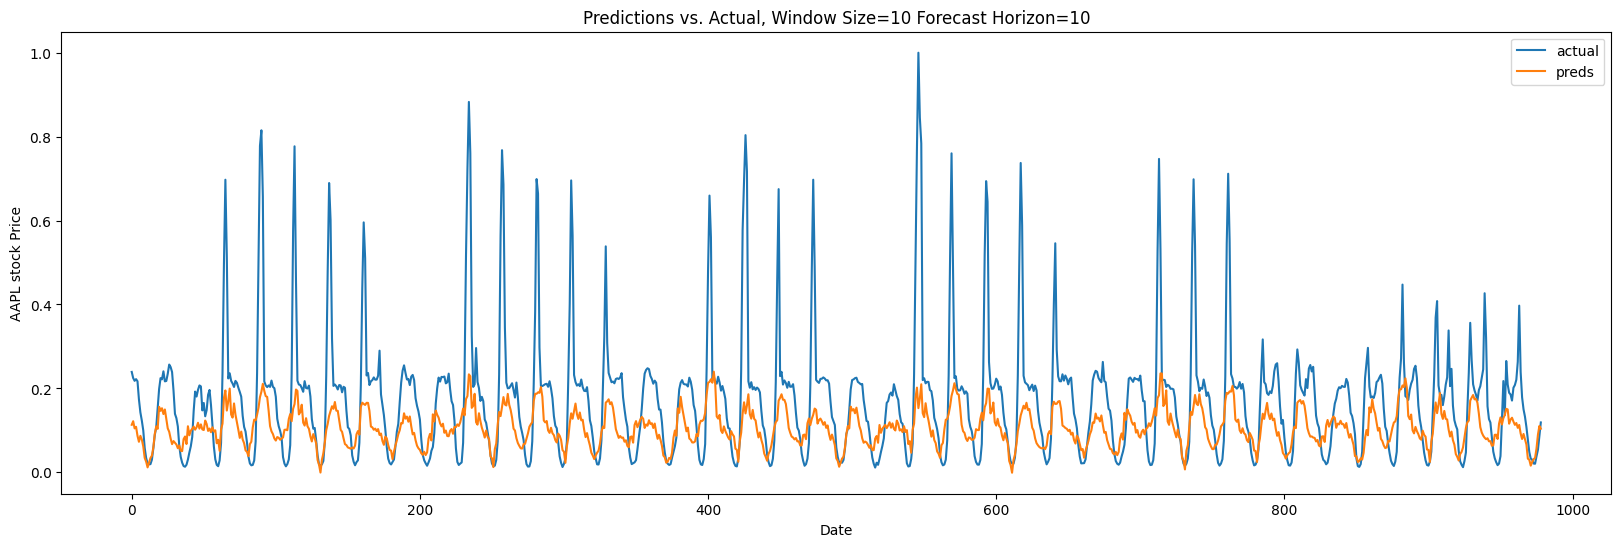

RMSE: 0.14421414036541372


In [ ]:
testPredictions = model.predict(X_test)
testPredictions = testPredictions[::ForecastHorizon]
testPredictions = testPredictions.reshape(testPredictions.shape[0]*testPredictions.shape[1])


y_test_tmp = y_test[::ForecastHorizon]
y_test_tmp = y_test_tmp.reshape(y_test_tmp.shape[0]*y_test_tmp.shape[1])

plot_results(y_test_tmp, testPredictions, title_suffix="Window Size={WindowSize} Forecast Horizon={ForecastHorizon}".format(WindowSize=WindowSize, ForecastHorizon=ForecastHorizon))
mse = ((y_test_tmp- testPredictions)**2).mean()
print("RMSE:", mse**0.5)

In [ ]:
import numpy as np
# import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
import tensorflow as tf
from tensorflow.keras import layers, models
from matplotlib import pyplot as plt
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

class FourierInformedTimeSeriesForecaster:


    def __init__(self, TimeSeries, WindowSize, ForecastHorizon, MaskPercentage):
        self.TimeSeries = TimeSeries
        self.WindowSize = WindowSize
        self.ForecastHorizon = ForecastHorizon
        self.MaskPercentage = MaskPercentage
        self.TargetComplexShape = None
        self.FrequenciesMeasured = None

    def seriesToRollingWindowSeries(self, series, windowSize, univariate=False):
        data = []
        if not univariate:
            for i in range(len(series)-windowSize):      # Each window
                features = []
                for featureNum in range(series.shape[-1]):        # Each feature
                    features.append(series[i:i+windowSize, featureNum])
                data.append(features)
        else:
            for i in range(len(series)-windowSize):      # Each window
                data.append(series[i:i+windowSize])
        return np.array(data)

    def timeSeriesToFrequencies(self, timeSeries, samplingFrequency):
        """
        Returns the frequency values and respective intensities in a time signal
        """
        intensities = fft(timeSeries)
        frequencies = np.fft.fftfreq(len(intensities), 1/samplingFrequency)
        return frequencies, intensities

    def flattenComplex(self, ComplexValuedArray):
        # global self.TargetComplexShape
        self.TargetComplexShape = ComplexValuedArray.shape
        # print(TARGET_COMPLEX_SHAPE)
        real, imag = ComplexValuedArray.real, ComplexValuedArray.imag
        realValuedArray = list(real)+list(imag)
        return np.array(realValuedArray)

    def unflattenComplex(self, realValuedArray, targetShape):
        arrayLength = len(realValuedArray)//2
        real, imag = realValuedArray[:arrayLength], realValuedArray[arrayLength:]
        complexValuedArray = np.empty(targetShape, dtype=np.complex128)
        complexValuedArray.real = real
        complexValuedArray.imag = imag
        return complexValuedArray

    def frequenciesToTimeSeries(self, frequencyMagnitudes, targetShape):
        """
        Returns the time representation of the input set of signals
        """
        if not np.iscomplex(frequencyMagnitudes).any():      ## Not a complex amplitude
            frequencyMagnitudes = self.unflattenComplex(frequencyMagnitudes, targetShape)
        frequencyMagnitudes = np.pad(frequencyMagnitudes, (self.WindowSize-len(frequencyMagnitudes), 0), 'constant')            ## Fill up the masked values with zeros
        timeSignal = ifft(frequencyMagnitudes).real
        return timeSignal

    def rollingWindowTimeSeriesToRollingWindowFrequencies(self, rollingWindowTimeSeries, samplingFrequency=1, flatten=True, univariate=False, mask=True, maskPercentage=0):
        rollingWindowFrequencies = []
        for dataPointIndex in range(len(rollingWindowTimeSeries)):
            featureFrequencyMagnitudes = []
            for featureIndex in range(rollingWindowTimeSeries.shape[1]):
                _, frequencyMagnitudes = self.timeSeriesToFrequencies(rollingWindowTimeSeries[dataPointIndex, featureIndex, :], 1)
                if mask:
                    maskIndex = int(len(frequencyMagnitudes)*(maskPercentage))
                    frequencyMagnitudes = frequencyMagnitudes[maskIndex:]
                if flatten:
                    frequencyMagnitudes = self.flattenComplex(frequencyMagnitudes)
                featureFrequencyMagnitudes.append(frequencyMagnitudes)
            rollingWindowFrequencies.append(featureFrequencyMagnitudes)
        return np.array(rollingWindowFrequencies)


    def rollingWindowFrequenciesToRollingWindowTimeSeries(self, rollingWindowFrequencies, targetShape):
        rollingWindowTimeSeries = []
        for i in range(len(rollingWindowFrequencies)):
            timeSeries = self.frequenciesToTimeSeries(rollingWindowFrequencies[i], targetShape)
            rollingWindowTimeSeries.append(timeSeries)
        return np.array(rollingWindowTimeSeries)


    def rollingWindowTimeSeriesToTimeSeries(self, rollingWindowTimeSeries, forecastHorizon=1):
        timeSeries = list(rollingWindowTimeSeries[0])
        for i in range(1, len(rollingWindowTimeSeries), forecastHorizon):
            # timeSeries.append(rollingWindowTimeSeries[i][-1])
            timeSeries+=list(rollingWindowTimeSeries[i][-forecastHorizon:])
        return np.array(timeSeries)


    def DataPreprocessor(self, univariate=False, trainRatio=0.6, valRatio=0.2, pca=True, pcaComponents=0):
        trainSplitIndex = int(len(self.TimeSeries)*trainRatio)
        valSplitIndex = int(len(self.TimeSeries)*(trainRatio+valRatio))

        self.rollingWindowTimeSeries = self.seriesToRollingWindowSeries(self.TimeSeries, self.WindowSize)
        self.rollingWindowFrequencies = self.rollingWindowTimeSeriesToRollingWindowFrequencies(self.rollingWindowTimeSeries, maskPercentage=self.MaskPercentage)

        self.X, self.y = self.rollingWindowFrequencies[:-1], self.rollingWindowFrequencies[:, -1][1:]
        self.X = self.X.reshape((self.X.shape[0], self.X.shape[1]*self.X.shape[2]))

        if pca:
            covar_matrix = PCA(n_components = pcaComponents)
            principalComponents = covar_matrix.fit_transform(self.X)
            self.X = principalComponents


        self.X_train, self.y_train = self.X[:trainSplitIndex], self.y[:trainSplitIndex]
        self.X_val, self.y_val = self.X[trainSplitIndex:valSplitIndex], self.y[trainSplitIndex:valSplitIndex]
        self.X_test, self.y_test = self.X[valSplitIndex:], self.y[valSplitIndex:]


    def TrainSetup(self, hiddenLayers, hiddenUnits):
        # numInputs = 100
        # Define the number of input and output dimensions
        input_dim = self.X_train.shape[-1]
        output_dim = self.y_train.shape[-1]
        hidden_layers = hiddenLayers
        hidden_units = hiddenUnits

        # Define the model
        self.model = models.Sequential()

        # Add the input layer
        self.model.add(layers.Input(shape=(input_dim,)))

        # Add the hidden layers
        for _ in range(hidden_layers):
            self.model.add(layers.Dense(hidden_units, activation='relu'))

        # Add the output layer
        # self.model.add(layers.Dense(hidden_units))
        # self.model.add(layers.Dense(hidden_units))
        self.model.add(layers.Dense(output_dim))

        # Compile the model
        self.model.compile(optimizer='adam', loss='mse')  # You can change the loss function as needed

        # Print model summary
        self.model.summary()

    def plot_results(self, actual, preds, image_path=None, title_suffix=None):
        """
        Plots training data in blue, actual values in red, and predictions in green,
        over time.
        """
        fig, ax = plt.subplots(figsize=(20,6))
        plot_actual = actual[1:]
        plot_preds = preds[1:]
        ax.plot(plot_actual, label='Expected')
        ax.plot(plot_preds, label='Predicted')
        if title_suffix==None:
            ax.set_title('Predictions vs. Actual')
        else:
            # ax.set_title(f'Predictions vs. Actual, {title_suffix}')
            ax.set_title(title_suffix)
        ax.set_xlabel('Date')
        # ax.set_ylabel(xlabel)
        ax.legend()
        plt.show()

    def driver(self, univariate=False, trainRatio=0.8, valRatio=0.1, hiddenLayers=3, hiddenUnits=3, epochs=20, pca=True, pcaComponents=20):
        initialTime = time()
        self.DataPreprocessor(univariate, trainRatio, valRatio, pca=pca, pcaComponents=pcaComponents)
        self.TrainSetup(hiddenLayers, hiddenUnits)
        trainHistory = self.model.fit(self.X_train, self.y_train, epochs=epochs, validation_data=(self.X_val, self.y_val))
        totalTime = time() - initialTime

        testPredictions = self.model.predict(self.X_test)

        pred = self.rollingWindowFrequenciesToRollingWindowTimeSeries(testPredictions, self.TargetComplexShape)
        actual = self.rollingWindowFrequenciesToRollingWindowTimeSeries(self.y_test, self.TargetComplexShape)

        pred = self.rollingWindowTimeSeriesToTimeSeries(pred, forecastHorizon=1)
        actual = self.rollingWindowTimeSeriesToTimeSeries(actual, forecastHorizon=1)


        predicted = self.model.predict(self.X_test)
        predicted = self.rollingWindowFrequenciesToRollingWindowTimeSeries(predicted, self.TargetComplexShape)
        predicted = self.rollingWindowTimeSeriesToTimeSeries(predicted, forecastHorizon=self.ForecastHorizon)
        # print("Predicted:", predicted.shape)
        predicted = predicted.reshape(predicted.shape[0], 1)
        predicted = yScaler.inverse_transform(predicted)

        expected = self.rollingWindowFrequenciesToRollingWindowTimeSeries(self.y_test, self.TargetComplexShape)
        expected = self.rollingWindowTimeSeriesToTimeSeries(expected, forecastHorizon=self.ForecastHorizon)
        # print("Expected:", expected.shape)
        expected = expected.reshape(expected.shape[0], 1)
        expected = yScaler.inverse_transform(expected)


        # print(self.X_test.shape, self.y_test.shape)
        # print(expected.shape, predicted.shape)

        mse = ((expected - predicted)**2).mean()

        information = {"expected": expected, "predicted": predicted, "model": self.model, "timeTaken": totalTime, "trainHistory": trainHistory, "mse": mse}
        return information

In [ ]:
inputParameters = [
    {
        "Data": TimeSeries,
        "WindowSize": 20,
        "ForecastHorizon": 20,
        "MaskPercentage": 0.0,
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "HiddenLayers": 1,
        "HiddenUnits": 2,
        "Epochs": 20,
        "Pca": True,
        "PcaComponents": 50
    },
    {
        "Data": TimeSeries,
        "WindowSize": 50,
        "ForecastHorizon": 5,
        "MaskPercentage": 0.0,
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "HiddenLayers": 1,
        "HiddenUnits": 2,
        "Epochs": 20,
        "Pca": True,
        "PcaComponents": 50
    },
    {
        "Data": TimeSeries,
        "WindowSize": 100,
        "ForecastHorizon": 5,
        "MaskPercentage": 0.0,
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "HiddenLayers": 1,
        "HiddenUnits": 2,
        "Epochs": 20,
        "Pca": True,
        "PcaComponents": 50
    },
    {
        "Data": TimeSeries,
        "WindowSize": 10,
        "ForecastHorizon": 10,
        "MaskPercentage": 0.0,
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "HiddenLayers": 1,
        "HiddenUnits": 2,
        "Epochs": 20,
        "Pca": True,
        "PcaComponents": 50
    },
    {
        "Data": TimeSeries,
        "WindowSize": 50,
        "ForecastHorizon": 10,
        "MaskPercentage": 0.0,
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "HiddenLayers": 1,
        "HiddenUnits": 2,
        "Epochs": 20,
        "Pca": True,
        "PcaComponents": 50
    },
    {
        "Data": TimeSeries,
        "WindowSize": 100,
        "ForecastHorizon": 10,
        "MaskPercentage": 0.0,
        "TrainRatio": 0.8,
        "ValRatio": 0.1,
        "HiddenLayers": 1,
        "HiddenUnits": 2,
        "Epochs": 20,
        "Pca": True,
        "PcaComponents": 50
    }
]

outputs = []

In [ ]:
!rm outputs*.pkl

In [ ]:
outputs = []
for index, params in enumerate(inputParameters):
    tmp = {"inputParameters": params, "runs":[]}
    for i in range(5):
        fourierModule = FourierInformedTimeSeriesForecaster(params["Data"], params["WindowSize"], params["ForecastHorizon"], params["MaskPercentage"])
        information = fourierModule.driver(trainRatio=params["TrainRatio"], valRatio=params["ValRatio"],
                        hiddenLayers=params["HiddenLayers"], hiddenUnits=params["HiddenUnits"], epochs=params["Epochs"], pca=params["Pca"], pcaComponents=params["PcaComponents"])
        tmp["runs"].append(information)
    outputs.append(tmp)
    with open("outputs_"+str(index)+"_"+str(len(inputParameters))+".pkl", "wb") as f:
        pkl.dump(outputs, f)

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_90 (Dense)            (None, 2)                 102       
                                                                 
 dense_91 (Dense)            (None, 40)                120       
                                                                 
Total params: 222 (888.00 Byte)
Trainable params: 222 (888.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
250/250 [==============================] - 1s 2ms/step - loss: 0.2642 - val_loss: 0.4251
Epoch 2/20
250/250 [==============================] - 0s 2ms/step - loss: 0.1497 - val_loss: 0.3468
Epoch 3/20
250/250 [==============================] - 1s 2ms/step - loss: 0.1172 - val_loss: 0.2926
Epoch 4/20
250/250 [==============================] - 0s 2ms/step - loss: 0.0922 - val_loss: 0.2456
Epoch 5/20


In [ ]:
!cp outputs*.pkl drive/MyDrive/CS297/Demo3/FourierResults

In [ ]:
data = None
with open("drive/MyDrive/CS297/Demo3/FourierResults/outputs_5_6.pkl", "rb") as f:
    data = pkl.load(f)

for d in data:
    mean = 0
    meanTime = 0
    for run in d["runs"]:
        # print(run["mse"])
        mean+=run["mse"]
        meanTime+=run["timeTaken"]
    print(mean/5, meanTime/5)
    print("-"*100)

0.002898320554463442 19.44711799621582
----------------------------------------------------------------------------------------------------
0.00321197476207821 21.681945610046387
----------------------------------------------------------------------------------------------------
0.0037497871382869133 22.300878286361694
----------------------------------------------------------------------------------------------------
0.001287440008156017 17.918078804016112
----------------------------------------------------------------------------------------------------
0.0033146734237167142 23.211851930618288
----------------------------------------------------------------------------------------------------
0.003472462963883508 24.02676692008972
----------------------------------------------------------------------------------------------------


In [ ]:
import pandas as pd
# train = pd.read_csv("data/train.csv",
#                  parse_dates=["datetime"],
#                  index_col=["datetime"])
# train.head()
df = df[[c for c in df if c not in ['values']] + ['values']]
train = df
from sklearn.preprocessing import MinMaxScaler

# Assuming 'train' and 'test' are your dataframes and 'nat_demand' is a column to exclude from scaling
# columns_to_scale = [col for col in train.columns if col != 'nat_demand']

# Create a scaler and fit it only on the columns to be scaled
scaler = MinMaxScaler()
scaler.fit(train)

# Transform the selected columns in both the train and test sets
train_scaled = train.copy()
train_scaled = scaler.transform(train)



# X = train_scaled[:, :-1]#[:10000]
# y = train_scaled[:, -1]#[:10000]

# # X = train.values[:, 1:][:10000]
# # y = train.values[:, 0][:10000]

# forecastHorizon = 10
# X = X[:-forecastHorizon]
# y = y[forecastHorizon:]

In [ ]:
WindowSize = 100
ForecastHorizon = 100
MaskPercentage = 0.00
# TimeSeries = dataset.values #train #.values
# TimeSeries = train.values #.values
TimeSeries = train_scaled
TARGET_COMPLEX_SHAPE = None
FrequenciesToConsider = int(WindowSize*(1-MaskPercentage))

univariate = False
trainRatio = 0.8
valRatio = 0.1
FREQUENCIES_MEASURED = None

In [ ]:
ft.X_train.shape

(8000, 800)

In [ ]:
ft = FourierInformedTimeSeriesForecaster(train_scaled, WindowSize, ForecastHorizon, MaskPercentage=0.0)
ft.DataPreprocessor(univariate, trainRatio, valRatio, pca=False, pcaComponents=20)
ft.TrainSetup(1, 3)
trainHistory = ft.model.fit(ft.X_train, ft.y_train, epochs=20, validation_data=(ft.X_val, ft.y_val))



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 3)                 3003      
                                                                 
 dense_37 (Dense)            (None, 200)               800       
                                                                 
Total params: 3803 (14.86 KB)
Trainable params: 3803 (14.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
250/250 [==============================] - 1s 3ms/step - loss: 0.7473 - val_loss: 1.2444
Epoch 2/20
250/250 [==============================] - 1s 2ms/step - loss: 0.2914 - val_loss: 0.9563
Epoch 3/20
250/250 [==============================] - 0s 2ms/step - loss: 0.2525 - val_loss: 0.8267
Epoch 4/20
250/250 [==============================] - 1s 2ms/step - loss: 0.2148 - val_loss: 0.7281
Epoch 5/20
250/2

29/29 [==============================] - 0s 2ms/step


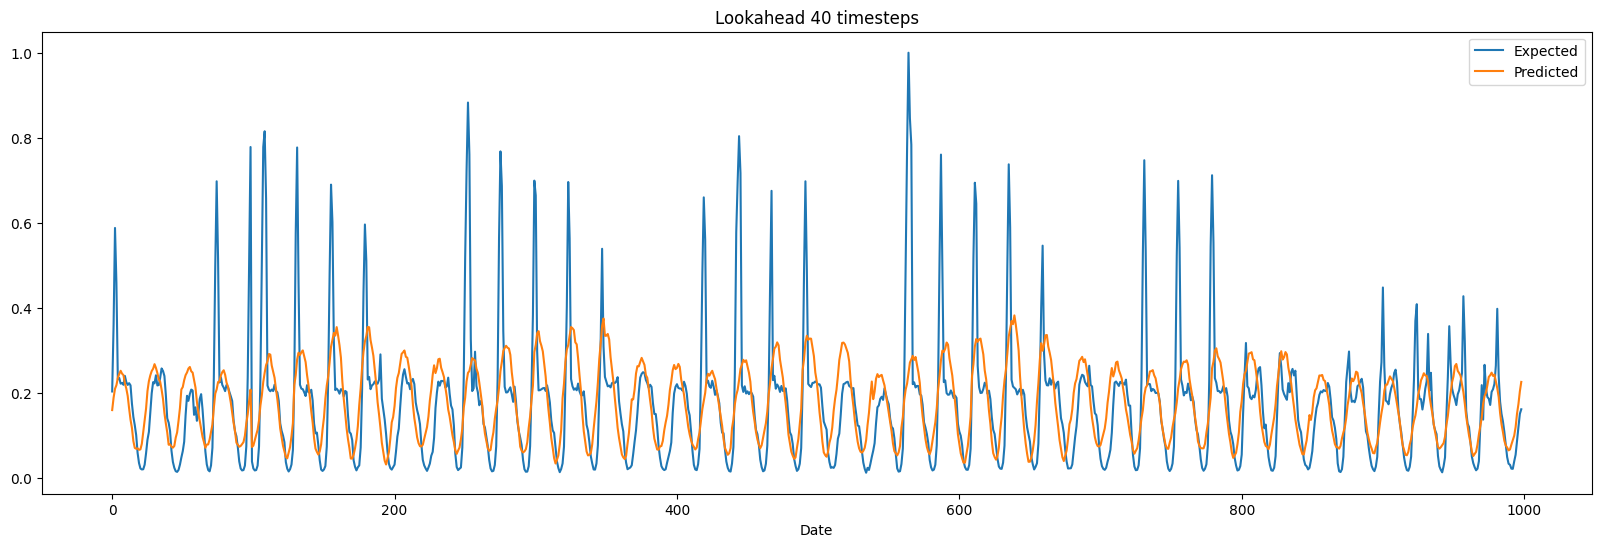

RMSE: 0.12370479581845352


In [ ]:
testPredictions = ft.model.predict(ft.X_test)
pred = ft.rollingWindowFrequenciesToRollingWindowTimeSeries(testPredictions, ft.TargetComplexShape)
pred = ft.rollingWindowTimeSeriesToTimeSeries(pred, forecastHorizon=10)
actual = ft.rollingWindowFrequenciesToRollingWindowTimeSeries(ft.y_test, ft.TargetComplexShape)
actual = ft.rollingWindowTimeSeriesToTimeSeries(actual, forecastHorizon=10)

ft.plot_results(actual, pred, title_suffix='Lookahead 40 timesteps')
mse = ((actual- pred)**2).mean()
print("RMSE:", mse**0.5)